NLP
===
- Bag of Words
- TFIDF
- Doc2Vec

# 1. Build feature vectors for song lyrics

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
df_master_song = pd.read_json('../../data/MasterSongList.json')
df_master_song.head()

,_id,album,artist,audio_features,context,decades,genres,lyrics_features,moods,name,new_context,picture,recording_id,sub_context,yt_id,yt_views
0,{'$oid': '52fdfb440b9398049f3d7a8c'},Gangnam Style (강남스타일),PSY,"[11, 0.912744, 0.083704, 132.069, 0.293137, 0....",[work out],[],[pop],"[oppa, gangnam, style, gangnam, style, najeneu...","[energetic, motivational]",Gangnam Style (강남스타일),work out,http://images.musicnet.com/albums/073/463/405/...,50232.0,[working out: cardio],9bZkp7q19f0,2450112089
1,{'$oid': '52fdfb3d0b9398049f3cbc8e'},Native,OneRepublic,"[6, 0.7457039999999999, 0.11995499999999999, 1...",[energetic],[2012],[pop],"[lately, i, ve, been, i, ve, been, losing, sle...",[happy],Counting Stars,energetic,http://images.musicnet.com/albums/081/851/887/...,5839.0,[energy boost],hT_nvWreIhg,1020297206
2,{'$oid': '52fdfb420b9398049f3d3ea5'},Party Rock Anthem,LMFAO,"[5, 0.709932, 0.231455, 130.03, 0.121740999999...","[energetic, energetic, energetic, energetic]",[],[],"[party, rock, yeah, woo, let, s, go, party, ro...","[happy, celebratory, rowdy]",Party Rock Anthem,housework,http://images.musicnet.com/albums/049/414/127/...,52379.0,"[energy boost, pleasing a crowd, housework, dr...",KQ6zr6kCPj8,971128436
3,{'$oid': '52fdfb410b9398049f3d1eac'},Gentleman,PSY,"[3, 0.705822, 0.053292, 126.009, 0.126016, 0.0...","[party, party, party, party, party, party]",[2010s],[dance],"[alagamun, lan, weh, wakun, heya, hanun, gon, ...","[happy, energetic, celebratory]",Gentleman,energetic,http://images.musicnet.com/albums/082/950/461/...,12353.0,"[driving in the left lane, energy boost, girls...",ASO_zypdnsQ,892096527
4,{'$oid': '52fdfb400b9398049f3d0b19'},On The Floor,Jennifer Lopez,"[3, 0.741757, 0.07277399999999999, 129.985, 0....","[party, party]",[2000s],[reggaeton],"[j, lo, the, other, side, out, my, mine, it, s...",[energetic],On The Floor,work out,http://images.musicnet.com/albums/050/131/765/...,29502.0,"[working out: cardio, dance party: sweaty]",t4H_Zoh7G5A,873285189


## Format input
- lower case
- remove punctuation
- stop word
- stemming

In [30]:
# Filter empty lyrics_features
df_master_song = df_master_song[df_master_song.loc[:, 'lyrics_features'].str.len() > 0]
df_master_song = df_master_song[df_master_song.loc[:, 'moods'].str.len() > 0]
df_master_song.reset_index(drop=True, inplace=True)

In [31]:
df_master_song['lyrics_features'] = df_master_song.loc[:, 'lyrics_features'].str.join(' ')

In [32]:
from string import punctuation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer

def clean_text(text):
    processing_text = text.lower()
    translate_func = str.maketrans('', '', punctuation)
    processing_text = processing_text.translate(translate_func)
    stemmer = SnowballStemmer('english')
    clean_token = [ stemmer.stem(word) for word in processing_text.split() if word not in ENGLISH_STOP_WORDS ]
    processing_text = ' '.join(clean_token)
    return processing_text

In [33]:
df_master_song['lyrics_features'] = df_master_song.loc[:,'lyrics_features'].apply(clean_text)

## Filter mood for bow and tfidf

In [34]:
df_moods = df_master_song.loc[:, 'moods'].str.join(',').str.get_dummies(',')
df_moods.head()

,aggressive,angsty,atmospheric,campy,celebratory,classy,cocky,cold,earthy,energetic,...,seductive,sexual,soothing,spacey,sprightly,sweet,trashy,trippy,visceral,warm
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [173]:
# base on df_moods to choose 2 kind of moods
def select_moods(moods_1, moods_2):
    selected_row_final = []
    selected_row_1 = df_moods.loc[:, moods_1] == True
    selected_row_2 = df_moods.loc[:, moods_2] == True
    df_master_song_moods = pd.concat((df_master_song, df_moods), axis=1)

    # Make sure we get row that happy xor sad that means no row both happy and sad
    selected_row_final = (selected_row_1 != selected_row_2)
    df_lyrics_features = df_master_song_moods.loc[selected_row_final, ['lyrics_features', moods_1, moods_2]]
    df_lyrics_features['target'] = df_lyrics_features.loc[:, moods_1]
    return df_lyrics_features

df_lyrics_features = select_moods('happy', 'sad')
df_lyrics_features.target.value_counts()

1    1757
0    1249
Name: target, dtype: int64

> Dataset a little bit unbalance

In [120]:
def balance_dataset(df):
    min_features = min(df.target.value_counts())
    new_df_1 = df.loc[df.loc[:, 'target'] == 1, :].sample(n=min_features)
    new_df_2 = df.loc[df.loc[:, 'target'] == 0, :].sample(n=min_features)
    new_df = pd.concat([new_df_1, new_df_2], axis = 0)
    return new_df
df_lyrics_features_bal = balance_dataset(df_lyrics_features)
df_lyrics_features_bal.target.value_counts()

1    1249
0    1249
Name: target, dtype: int64

## Bag of Words

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [112]:
def bow_accuracy(df, ngrams):
    print(ngrams)
    bow = CountVectorizer(ngram_range=ngrams)
    lyrics_features_bow = bow.fit_transform(df.loc[:, 'lyrics_features'])
    X_train, X_test, y_train, y_test = train_test_split(lyrics_features_bow, df.loc[:, 'happy'], test_size=0.3, random_state = 101)
    lr = LogisticRegression().fit(X_train, y_train)
    y_predict = lr.predict(X_test)
    return accuracy_score(y_test, y_predict)

ngrams = range(1, 10)
bow_acc = [ bow_accuracy(df_lyrics_features, (1, ngram)) for ngram in ngrams ]
print(bow_acc)

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
[0.6818181818181818, 0.7139689578713969, 0.7172949002217295, 0.7172949002217295, 0.7128603104212861, 0.7139689578713969, 0.7128603104212861, 0.7195121951219512, 0.7195121951219512]


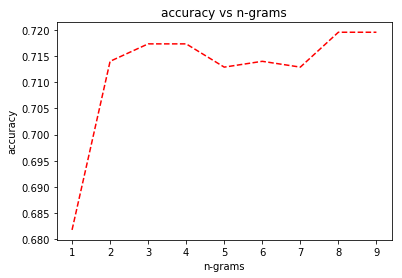

In [121]:
f, ax = plt.subplots()
ax.plot(ngrams, bow_acc, 'r--', label='accuracy')
ax.set_title('accuracy vs n-grams')
plt.xlabel('n-grams')
plt.ylabel('accuracy')
plt.show()


(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
[0.6613333333333333, 0.7026666666666667, 0.7053333333333334, 0.6986666666666667, 0.7053333333333334, 0.7013333333333334, 0.708, 0.704, 0.7026666666666667]


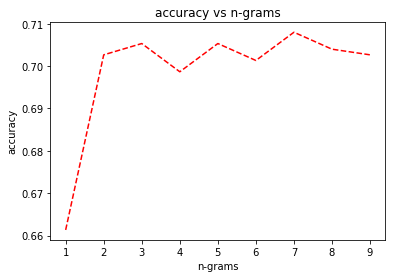

In [123]:
ngrams = range(1, 10)
bow_acc_bal = [ bow_accuracy(df_lyrics_features_bal, (1, ngram)) for ngram in ngrams]
print(bow_acc_bal)

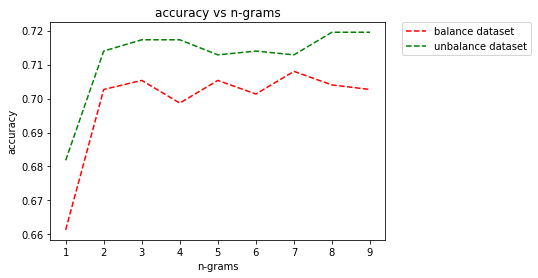

In [125]:
f, ax = plt.subplots()
ax.plot(ngrams, bow_acc_bal, 'r--', label='balance dataset')
ax.plot(ngrams, bow_acc, 'g--', label='unbalance dataset')
ax.set_title('accuracy vs n-grams')
plt.xlabel('n-grams')
plt.ylabel('accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## TF-IDF

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_1 = TfidfVectorizer()

In [69]:
lyrics_features_tfidf_1 = tfidf_1.fit_transform(df_lyrics_features.loc[:, 'lyrics_features'])

In [126]:
lyrics_features_tfidf_1.shape

(3006, 18837)

In [140]:
def tfidf_accuracy(df, ngrams):
    tfidf = TfidfVectorizer(ngram_range=ngrams).fit_transform(df.loc[:, 'lyrics_features'])
    X_train, X_test, y_train, y_test = train_test_split(tfidf, df.loc[:, 'target'], test_size=0.1, random_state=101)
    lr = LogisticRegression().fit(X_train, y_train)
    return accuracy_score(y_test, lr.predict(X_test))
    
ngrams = [ (1, ngram) for ngram in range(1, 5) ]
tfidf_accuracy_unbal = [ tfidf_accuracy(df_lyrics_features    , ngram) for ngram in ngrams ]
tfidf_accuracy_bal   = [ tfidf_accuracy(df_lyrics_features_bal, ngram) for ngram in ngrams ]
print(tfidf_accuracy_unbal)
print(tfidf_accuracy_bal)

[0.707641196013289, 0.7109634551495017, 0.6810631229235881, 0.6179401993355482]
[0.72, 0.708, 0.72, 0.728]


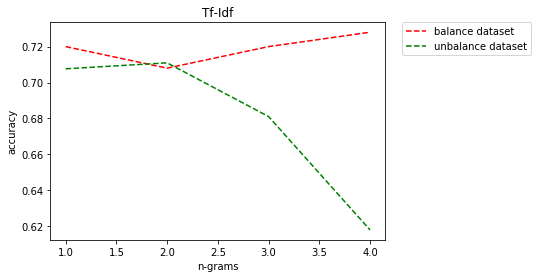

In [141]:
f, ax = plt.subplots()
ax.plot(list(zip(*ngrams))[1], tfidf_accuracy_bal, 'r--', label='balance dataset')
ax.plot(list(zip(*ngrams))[1], tfidf_accuracy_unbal, 'g--', label='unbalance dataset')
ax.set_title('Tf-Idf')
plt.xlabel('n-grams')
plt.ylabel('accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Doc2Vec

In [142]:
from gensim.models import Doc2Vec

In [143]:
%run Doc2VecHelperFunctions.ipynb

In [144]:
convert_lyrics_to_d2v(df_master_song.loc[:, 'lyrics_features'].tolist())

In [148]:
d2v_model = Doc2Vec.load('song_lyrics.d2v')

## train test set

In [200]:
df_lyrics_features['d2v'] = df_lyrics_features.index.map(lambda x: d2v_model[x])
df_lyrics_features_bal['d2v'] = df_lyrics_features_bal.index.map(lambda x: d2v_model[x])

In [199]:
def d2v_accuracy(df):
    X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'd2v'].tolist(), df.loc[:, 'target'], test_size=0.1, random_state=101)
    lr = LogisticRegression().fit(X_train, y_train)
    return accuracy_score(y_test, lr.predict(X_test))
d2v_accuracy(df_lyrics_features)
d2v_accuracy(df_lyrics_features_bal)

0.712